# Calculating Claim Statistics for a Subset of Patents using the Google Patents Public Datasets on BigQuery.

-----------------

Copyright 2017 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0
     
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


## Overview

Imagine you're analyzing a subset of patents and want to do some text analysis of the first independent claim. To do this, you'd need to be able to join your list of patent publication numbers with a dataset containing the patent text. Additionally, you'd need a method to extract the first claim from the rest of the claims. This notebook is a demonstration of one method to perform this analysis using python, BigQuery, and Google's [new public dataset on patents](https://cloud.google.com/bigquery/public-data/google-patents). 

What follows is a walkthrough of how to extract the first claim from a set of US Patent publications and run a few summary statistics against the first claim. The set of patents we analyze in this notebook is a random sample of 20,000 patents filed between 1995 and present in the G06F Cooperative Patent Classification (CPC) code, however this analysis could be repeated for any arbitrary list of patents of interest. 

The steps we'll use to get there are:
1. Create a new BigQuery "dataset" where we can store our results. For anyone new to bigquery, check out [the quickstart guide](https://cloud.google.com/bigquery/quickstart-web-ui).
2. Upload a list of patent publications we wish to analyze.
3. Join this list with Google's public patent data.
4. Extract the first claim using regular expressions and BigQuery User Defined Functions.
5. Calculate summary statistics about the first claims and plot results over time.


## Pre-requisites
- A google cloud account with access to BigQuery. If you don't have an account yet, [this page](https://cloud.google.com/free/) will guide you through the process to get started with an account and access the free tier of services.
- Basic knowledge of how to run a query using the BigQuery web UI. If you're new to this, check out [this page](https://cloud.google.com/bigquery/public-data/) for a quick intro.
- Basic knowledge of [pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/10min.html) and python programming.
- A few python packages (pandas, seaborn, matplotlib and google-api-python-client.

In [1]:
import os
print("PATH:", os.environ.get('PATH'))

PATH: C:\Anaconda;C:\Anaconda\Library\mingw-w64\bin;C:\Anaconda\Library\usr\bin;C:\Anaconda\Library\bin;C:\Anaconda\Scripts;C:\ProgramData\Oracle\Java\javapath;C:\Program Files (x86)\PC Connectivity Solution\;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Users\Николай\.dnx\bin;C:\Program Files\Microsoft DNX\Dnvm\;C:\Program Files\Microsoft SQL Server\120\Tools\Binn\;C:\Program Files\Microsoft SQL Server\130\Tools\Binn\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Files (x86)\Common Files\Acronis\SnapAPI\;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Users\Николай\AppData\Local\Microsoft\WindowsApps;C:\Users\Николай\AppData\Local\atom\bin;C:\Users\Николай\AppData\Local\Microsoft\WindowsApps;C:\Games\Google SDK\google-cloud

In [1]:
from __future__ import print_function
from google.cloud import bigquery
import pandas as pd
import matplotlib.pylab as plt
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
import uuid
import time
# Variables to be used throughout the notebook, replace with your project
# and desired dataset name.
PROJECT_ID = 'able-pottery-308914'
DEST_DATASET = 'claims_analysis_big13'

# Create a python client we can use for executing table creation queries
client = bigquery.Client(project=PROJECT_ID)
# Create an HTTP client for additional functionality.
credentials = GoogleCredentials.get_application_default()
http_client = discovery.build('bigquery', 'v2', credentials=credentials)

In [2]:
%matplotlib inline

## 1. Create a new BigQuery Dataset

During this analysis, we're going to be leveraging BigQuery to do most of the computation and we'll store our results in tables in BigQuery. To organize this, we'll need a new dataset to work with. We'll use the API to create a new dataset. For more on working with the BigQuery python client library, see [this page](https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python).

RUS: Во время этого анализа мы собираемся использовать BigQuery для выполнения большей части вычислений, и мы будем хранить наши результаты в таблицах в BigQuery. Чтобы организовать это, нам понадобится новый набор данных для работы. Мы будем использовать API для создания нового набора данных. Дополнительную информацию о работе с клиентской библиотекой Python BigQuery см. На [этой странице] (https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python).

In [3]:
dataset_ref = client.dataset(DEST_DATASET)
dataset = bigquery.Dataset(dataset_ref)
client.create_dataset(dataset)
print('Dataset {} created.'.format(dataset.dataset_id))

Dataset claims_analysis_big13 created.


## 2. Upload a list of Publication Numbers for analysis

 In this hypothetical example, we are planning to inspect the first claims from a set of patents. To do this, we need to get our list of publication numbers into BigQuery. Since this is just an example, we're going to use a random sample of 20k G06F patents we have saved to a CSV file and added to this repo, but this could be any set of patents you're interested in. We'll leverage [pandas "to_gbq" method]("https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_gbq.html") to simplify this. (Note, you could also do this from the [web UI or API.]("https://cloud.google.com/bigquery/loading-data") )


The steps we need to complete are:

1. Load a csv containing publication numbers.
2. Store these records in a new table in our BigQuery dataset. 

RUS: В этом гипотетическом примере мы планируем проверить первые формулы из набора патентов. Для этого нам нужно получить наш список номеров публикаций в BigQuery. Поскольку это всего лишь пример, мы собираемся использовать случайную выборку из 20 тысяч патентов G06F, которые мы сохранили в CSV-файл и добавили в это репо, но это может быть любой интересующий вас набор патентов. используйте [метод pandas "to_gbq"] ("https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_gbq.html"), чтобы упростить это. (Обратите внимание, вы также можете сделать это из [веб-интерфейса или API.] («Https://cloud.google.com/bigquery/loading-data»))


Нам необходимо выполнить следующие шаги:

1. Загрузите CSV, содержащий номера публикаций.
2. Сохраните эти записи в новой таблице в нашем наборе данных BigQuery.

In [4]:
# Load a list of patents from disk
df = pd.read_csv('./data/virtual-reality.csv')
df.head(5)

,publication_number
0,CN-103530495-B
1,US-10902663-B2
2,US-10083538-B2
3,KR-100963238-B1
4,TW-I672168-B


In [5]:
# Upload these to our dataset on BigQuery.
pubs_table = 'claim_text_publications'
full_table_path = '{}.{}'.format(DEST_DATASET, pubs_table)
df.to_gbq(destination_table=full_table_path,
          project_id=PROJECT_ID,
          if_exists='replace')

## 3. Join our uploaded list of publications with the patents-public-data on BigQuery to get the text of the claims, priority year, and classification code at the 4 digit level. 

In the next section, we'll begin using the public patent data which is available on Big Query. Among numerous other fields, this table includes the text of the patent claims, the CPC code, and priority date of the patent claims. Because BigQuery doesn't have a "create table as" syntax, we've created a function to handle constuction of a call to the BigQuery python API. This is simply a helper function, which takes a query and produces a table. This can also easily by done [using the web UI](https://cloud.google.com/bigquery/docs/tables).

The steps to be completed are:

1. Write a query which produces a 4 column table: publication number, priority year, CPC code (split at 4 digits), and the full text of the claims. 
2. Run this query, and write the results to a table in our project/dataset.

RUS: В следующем разделе мы начнем использовать общедоступные патентные данные, доступные в Big Query. Среди множества других полей эта таблица включает текст формулы изобретения, код CPC и дату приоритета формулы изобретения. Поскольку в BigQuery нет синтаксиса «создать таблицу как», мы создали функцию для обработки вызова API-интерфейса Python BigQuery. Это просто вспомогательная функция, которая принимает запрос и создает таблицу. Это также легко сделать [с помощью веб-интерфейса] (https://cloud.google.com/bigquery/docs/tables).

Необходимо выполнить следующие шаги:

1. Напишите запрос, который дает таблицу из 4 столбцов: номер публикации, приоритетный год, код CPC (разделенный на 4 цифры) и полный текст требований.
2. Запустите этот запрос и запишите результаты в таблицу в нашем проекте / наборе данных.

In [6]:
def create_table_as(query_string, dest_table, project_id=PROJECT_ID, dest_dataset=DEST_DATASET,
                    http_client=http_client, overwrite=True, use_legacy_sql=False):
  """Simulates a 'create table as' statement in BigQuery.

  Args:
    query_string: A string query that produces rows of data.
    dest_table: string table name to use for storing results.
    project_id: string project id to use for running query and storing results.
    dest_dataset: String name of dataset to use for storing results.
    http_client: An http client for use in inserting the BigQuery Job.
    overwrite: Should new data be appended to existing data or overwritten?
    use_legacy_sql: Defaults to standard_sql, but option to use legacy.

  Raises:
    Exception: If the BigQuery job finshes with an error, a general Exception is raised
    with the error message from BigQuery included.
  """
  write_disposition = 'WRITE_TRUNCATE'
  if not overwrite:
    write_disposition = 'WRITE_APPEND'
  config = {
      'kind': 'bigquery#job',
      'projectId': str(uuid.uuid4()),
      'configuration': {
          'query': {
              'query': query_string,
              'destinationTable': {
                  'projectId': project_id,
                  'datasetId': dest_dataset,
                  'tableId': dest_table
              },
              'createDisposition': 'CREATE_IF_NEEDED',
              'writeDisposition': write_disposition,
              'useLegacySql': use_legacy_sql
          }
      }
  }
  done = False
  request = http_client.jobs().insert(
      projectId=project_id, body=config).execute()
  job_id = request['jobReference']['jobId']
  while not done:
    jobs = http_client.jobs().list(projectId=project_id).execute()
    matches = [j for j in jobs['jobs'] if j['jobReference']['jobId'] == job_id]
    if matches[0]['state'] == 'DONE':
      if matches[0].get('errorResult'):
        raise Exception(
            'Create table failed: {}'.format(matches[0]['errorResult']))
      done = True
    print('Job still running...')
    time.sleep(5)

  print('Created table {}.'.format(dest_table))

In [7]:
#Последний запрос
query = """
#standardSQL

WITH P AS (
  SELECT 
  DISTINCT publication_number, 
  substr(cpc.code, 1,10) cpc4,
  floor(priority_date / 10000) priority_yr
  FROM `patents-public-data.patents.publications`,
  unnest(cpc) as cpc
#WHERE substr(cpc.code, 1,4) = 'G06F'
#AND floor(priority_date / 10000) >= 1995
#AND country_code = 'US'
  WHERE floor(priority_date / 10000) >= 1995
)

SELECT 
P.publication_number,
country_code,
P.priority_yr,
P.cpc4,
claims.text
FROM `patents-public-data.patents.publications` as pubs,
UNNEST(claims_localized) as claims
JOIN P 
  ON P.publication_number = pubs.publication_number
JOIN `{}.{}.{}` my_pubs
  ON pubs.publication_number = my_pubs.publication_number
WHERE claims.language = 'en'
""".format(PROJECT_ID, DEST_DATASET, pubs_table)
create_table_as(query, 'virtual-reality')

Job still running...
Job still running...
Job still running...
Job still running...
Job still running...
Created table virtual-reality.


In [8]:
#Создал ещё одну таблицу, которая возвращает кол-во цитирований (forward citations)
query = """
#standardSQL

SELECT c.publication_number AS Pub, COUNT(p.publication_number) AS CitedBy  
FROM `patents-public-data.patents.publications` AS p, UNNEST(citation) AS c 
GROUP BY c.publication_number
""".format(PROJECT_ID, DEST_DATASET, pubs_table)
create_table_as(query, 'virtual-reality-citations')

Job still running...
Job still running...
Job still running...
Job still running...
Job still running...
Created table virtual-reality-citations.


In [9]:
query = """
#standardSQL

SELECT *
FROM `able-pottery-308914.claims_analysis_big11.virtual-reality` as A
INNER JOIN `able-pottery-308914.claims_analysis_big11.virtual-reality-citations` as B ON A.publication_number = B.Pub;
""".format(PROJECT_ID, DEST_DATASET, pubs_table)
create_table_as(query, 'virtual-reality-mod0')

Job still running...
Job still running...
Job still running...
Job still running...
Created table virtual-reality-mod0.


### Lets inspect the contents of this new table we've created

We've now written these results to a table, lets take a look at the output. First, we'll pull down a random sample of 500 rows using a BigQuery trick for selecting a random sample (see below). We'll get the data with a handy pandas function, ["read_gbq"](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_gbq.html). Once we get the data in memory, let's look at the distribution of priority years and inspect a few example claims. 

- To get a random sample of roughly n_rows, we can simply include a statement in our where clause that looks like:

   ```where rand() < n_rows / total_rows_in_table```
   

- Since we have about 20k rows and we want a sample of about 500, this becomes:

   ```where rand() < 500 / 20000```
  
RUS: Теперь мы записали эти результаты в таблицу, давайте посмотрим на результат. Сначала мы извлечем случайную выборку из 500 строк, используя трюк BigQuery для выбора случайной выборки (см. Ниже). Мы получим данные с помощью удобной функции pandas "read_gbq". Как только мы получим данные в памяти, давайте посмотрим на распределение приоритетных лет и рассмотрим несколько примеров заявок.

- To get a random sample of roughly n_rows, we can simply include a statement in our where clause that looks like:

   ```where rand() < n_rows / total_rows_in_table```
   

- Since we have about 20k rows and we want a sample of about 500, this becomes:

  ```where rand() < 500 / 20000```

In [10]:
#query = """
#SELECT *
#FROM `{}.{}.virtual-reality`
#WHERE RAND() < 500/20000 
#""".format(PROJECT_ID, DEST_DATASET)
#df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

#Соберём своб табличку в Dataframe

query = """
SELECT *
FROM `{}.{}.virtual-reality-mod0`
""".format(PROJECT_ID, DEST_DATASET)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

In [11]:
# Quick visualization of the first 5 rows
df.head()

,publication_number,country_code,priority_yr,cpc4,text,Pub,CitedBy
0,US-5544161-A,US,1995.0,H04L2012/5,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500
1,US-5544161-A,US,1995.0,H04N21/643,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500
2,US-5544161-A,US,1995.0,H04H20/46,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500
3,US-5544161-A,US,1995.0,H04H20/42,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500
4,US-5544161-A,US,1995.0,H04N21/438,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500


In [12]:
#Добавляем новую колонну в df с default value = 1, нужно, чтобы потом далее составить матрицу PPM
df['Contains CPC'] = '1.0'
df.head()

,publication_number,country_code,priority_yr,cpc4,text,Pub,CitedBy,Contains CPC
0,US-5544161-A,US,1995.0,H04L2012/5,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0
1,US-5544161-A,US,1995.0,H04N21/643,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0
2,US-5544161-A,US,1995.0,H04H20/46,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0
3,US-5544161-A,US,1995.0,H04H20/42,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0
4,US-5544161-A,US,1995.0,H04N21/438,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0


In [13]:
#Пытаемся создать матрицу PPM (сделали матрицу из пивота, сделав индексами, т.е. строками номера патентов из колонки publication_number, столбцами коды CPC из колонки CPC4)
pivot_table = df.pivot(index='publication_number', columns='cpc4', values='Contains CPC')
pivot_table

cpc4,A01B1/00,A01B51/02,A01B51/023,A01B51/026,A01B59/06,A01B69/008,A01B76/00,A01B79/00,A01B79/005,A01B79/02,...,Y10T83/207,Y10T83/219,Y10T83/445,Y10T83/533,Y10T83/536,Y10T83/541,Y10T83/657,Y10T83/882,Y10T83/896,Y10T83/902
publication_number,,,,,,,,,,,,,,,,,,,,,
US-10001833-B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US-10002141-B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US-10002337-B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US-10002489-B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US-10003945-B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-RE45097-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US-RE45398-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US-RE45766-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#Обратно конвертируем пивот в датафрейм
pivot_table_df = pivot_table.reset_index()
#Заменяем значения NaN на 0
pivot_table_df = pivot_table_df.fillna(0.0)
pivot_table_df

cpc4,publication_number,A01B1/00,A01B51/02,A01B51/023,A01B51/026,A01B59/06,A01B69/008,A01B76/00,A01B79/00,A01B79/005,...,Y10T83/207,Y10T83/219,Y10T83/445,Y10T83/533,Y10T83/536,Y10T83/541,Y10T83/657,Y10T83/882,Y10T83/896,Y10T83/902
0,US-10001833-B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,US-10002141-B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,US-10002337-B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,US-10002489-B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,US-10003945-B2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7206,US-RE45097-E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7207,US-RE45398-E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7208,US-RE45766-E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7209,US-RE46195-E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
#pivot_table_df.to_csv('./data/pivot_table_df.csv')

PCM матрица готова, можно проверить её в выгрузке. Дальше можно считать матрицу отношений по коэффициенту Пирсона

In [15]:
PPM = pivot_table_df.set_index('publication_number').T
PPM.astype(float)

publication_number,US-10001833-B2,US-10002141-B2,US-10002337-B2,US-10002489-B2,US-10003945-B2,US-10004393-B2,US-10004660-B2,US-10004940-B2,US-10007117-B2,US-10007352-B2,...,US-RE44087-E,US-RE44095-E,US-RE44611-E,US-RE44782-E,US-RE45062-E,US-RE45097-E,US-RE45398-E,US-RE45766-E,US-RE46195-E,US-RE46309-E
cpc4,,,,,,,,,,,,,,,,,,,,,
A01B1/00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01B51/02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01B51/023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01B51/026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01B59/06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y10T83/541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y10T83/657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y10T83/882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


С этой матрицей не получилось построить матрицу PPM, corr() выдал нулевое значение. Зато с матрицей внизу, всё получилось.

In [16]:
PPM2 = df.pivot(index='cpc4', columns='publication_number', values='Contains CPC')
PPM2 = PPM2.reset_index()
PPM2 = PPM2.drop(columns='cpc4')
PPM2 = PPM2.fillna(0.0)
PPM2 = PPM2.astype(float)
PPM2

publication_number,US-10001833-B2,US-10002141-B2,US-10002337-B2,US-10002489-B2,US-10003945-B2,US-10004393-B2,US-10004660-B2,US-10004940-B2,US-10007117-B2,US-10007352-B2,...,US-RE44087-E,US-RE44095-E,US-RE44611-E,US-RE44782-E,US-RE45062-E,US-RE45097-E,US-RE45398-E,US-RE45766-E,US-RE46195-E,US-RE46309-E
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
corrMatrix = PPM2.corr()
corrMatrix

publication_number,US-10001833-B2,US-10002141-B2,US-10002337-B2,US-10002489-B2,US-10003945-B2,US-10004393-B2,US-10004660-B2,US-10004940-B2,US-10007117-B2,US-10007352-B2,...,US-RE44087-E,US-RE44095-E,US-RE44611-E,US-RE44782-E,US-RE45062-E,US-RE45097-E,US-RE45398-E,US-RE45766-E,US-RE46195-E,US-RE46309-E
publication_number,,,,,,,,,,,,,,,,,,,,,
US-10001833-B2,1.000000,-0.000704,-0.001220,-0.000890,-0.001178,-0.001044,-0.001260,-0.001220,-0.001373,0.157595,...,-0.000771,-0.000704,-0.000996,-0.001409,0.128431,-0.000629,-0.000315,-0.000629,-0.000545,-0.000996
US-10002141-B2,-0.000704,1.000000,-0.000862,-0.000629,-0.000833,-0.000738,-0.000891,-0.000862,-0.000971,-0.000445,...,-0.000545,-0.000498,-0.000704,-0.000996,-0.000545,-0.000445,-0.000222,-0.000445,-0.000385,-0.000704
US-10002337-B2,-0.001220,-0.000862,1.000000,-0.001091,-0.001443,-0.001279,-0.001543,-0.001494,-0.001682,-0.000771,...,-0.000945,-0.000862,-0.001220,-0.001726,-0.000945,-0.000771,-0.000386,-0.000771,-0.000668,-0.001220
US-10002489-B2,-0.000890,-0.000629,-0.001091,1.000000,-0.001054,-0.000934,-0.001127,-0.001091,-0.001228,-0.000563,...,-0.000690,-0.000629,-0.000890,-0.001260,-0.000690,-0.000563,-0.000281,-0.000563,-0.000488,-0.000890
US-10003945-B2,-0.001178,-0.000833,-0.001443,-0.001054,1.000000,-0.001236,-0.001491,-0.001443,-0.001625,-0.000745,...,-0.000913,-0.000833,-0.001178,-0.001667,-0.000913,-0.000745,-0.000372,0.133005,-0.000645,-0.001178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-RE45097-E,-0.000629,-0.000445,-0.000771,-0.000563,-0.000745,-0.000660,-0.000796,-0.000771,-0.000868,-0.000398,...,-0.000488,-0.000445,-0.000629,-0.000891,-0.000488,1.000000,-0.000199,-0.000398,-0.000345,-0.000629
US-RE45398-E,-0.000315,-0.000222,-0.000386,-0.000281,-0.000372,-0.000330,-0.000398,-0.000386,-0.000434,-0.000199,...,-0.000244,-0.000222,-0.000315,-0.000445,-0.000244,-0.000199,1.000000,-0.000199,-0.000172,-0.000315
US-RE45766-E,-0.000629,-0.000445,-0.000771,-0.000563,0.133005,-0.000660,-0.000796,-0.000771,-0.000868,-0.000398,...,-0.000488,-0.000445,-0.000629,-0.000891,-0.000488,-0.000398,-0.000199,1.000000,-0.000345,-0.000629



Матрица PPM (patent-to-patent matrix) готова

In [22]:
#Не нужная часть, сделал, чтобы прикинуть, как будет
mindf = pd.DataFrame(corrMatrix.min(axis=1))
print('Min value in correlation matrix:', mindf.min())
maxdf = pd.DataFrame(corrMatrix.max(axis=1))
print('Max value in correlation matrix:', maxdf.max())

Min value in correlation matrix: 0   -0.0079
dtype: float64
Max value in correlation matrix: 0    1.0
dtype: float64


Таким образом размерность будущей dissimilarity matrix будет [0, 1.044691], как в статье корейцев (стр. 233). Составить её можно, вычтя из 1 каждое значение (коэффициент Пирсона) матрицы корреляций (1-(-0.044691)) и (1-1.0) соответственно.

In [23]:
dissimilarity_matrix=1-corrMatrix
dissimilarity_matrix

publication_number,US-10001833-B2,US-10002141-B2,US-10002337-B2,US-10002489-B2,US-10003945-B2,US-10004393-B2,US-10004660-B2,US-10004940-B2,US-10007117-B2,US-10007352-B2,...,US-RE44087-E,US-RE44095-E,US-RE44611-E,US-RE44782-E,US-RE45062-E,US-RE45097-E,US-RE45398-E,US-RE45766-E,US-RE46195-E,US-RE46309-E
publication_number,,,,,,,,,,,,,,,,,,,,,
US-10001833-B2,0.000000,1.000704,1.001220,1.000890,1.001178,1.001044,1.001260,1.001220,1.001373,0.842405,...,1.000771,1.000704,1.000996,1.001409,0.871569,1.000629,1.000315,1.000629,1.000545,1.000996
US-10002141-B2,1.000704,0.000000,1.000862,1.000629,1.000833,1.000738,1.000891,1.000862,1.000971,1.000445,...,1.000545,1.000498,1.000704,1.000996,1.000545,1.000445,1.000222,1.000445,1.000385,1.000704
US-10002337-B2,1.001220,1.000862,0.000000,1.001091,1.001443,1.001279,1.001543,1.001494,1.001682,1.000771,...,1.000945,1.000862,1.001220,1.001726,1.000945,1.000771,1.000386,1.000771,1.000668,1.001220
US-10002489-B2,1.000890,1.000629,1.001091,0.000000,1.001054,1.000934,1.001127,1.001091,1.001228,1.000563,...,1.000690,1.000629,1.000890,1.001260,1.000690,1.000563,1.000281,1.000563,1.000488,1.000890
US-10003945-B2,1.001178,1.000833,1.001443,1.001054,0.000000,1.001236,1.001491,1.001443,1.001625,1.000745,...,1.000913,1.000833,1.001178,1.001667,1.000913,1.000745,1.000372,0.866995,1.000645,1.001178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-RE45097-E,1.000629,1.000445,1.000771,1.000563,1.000745,1.000660,1.000796,1.000771,1.000868,1.000398,...,1.000488,1.000445,1.000629,1.000891,1.000488,0.000000,1.000199,1.000398,1.000345,1.000629
US-RE45398-E,1.000315,1.000222,1.000386,1.000281,1.000372,1.000330,1.000398,1.000386,1.000434,1.000199,...,1.000244,1.000222,1.000315,1.000445,1.000244,1.000199,0.000000,1.000199,1.000172,1.000315
US-RE45766-E,1.000629,1.000445,1.000771,1.000563,0.866995,1.000660,1.000796,1.000771,1.000868,1.000398,...,1.000488,1.000445,1.000629,1.000891,1.000488,1.000398,1.000199,0.000000,1.000345,1.000629


In [24]:
#Проверка dissimilarity_matrix
min_dissimilarity_matrix = pd.DataFrame(dissimilarity_matrix.min(axis=1))
print('Min value in dissimilarity matrix:', min_dissimilarity_matrix.min())
max_dissimilarity_matrix = pd.DataFrame(dissimilarity_matrix.max(axis=1))
print('Max value in dissimilarity matrix:', max_dissimilarity_matrix.max())

Min value in dissimilarity matrix: 0    0.0
dtype: float64
Max value in dissimilarity matrix: 0    1.0079
dtype: float64


Размерность dissimilarity matrix действительно [0, 1.044691]

## Multidimensional scaling (MDS)

Отлично объясняют про то, как сделать Multidimensional scaling (MDS)

https://stackoverflow.com/questions/38112853/how-to-obtain-the-eigenvalues-after-performing-multidimensional-scaling

If you're looking for eigenvalues per classical MDS then it's not hard to get them yourself. The steps are:

1. Get your distance matrix. Then square it.
2. Perform double-centering.
3. Find eigenvalues and eigenvectors
4. Select top k eigenvalues.
Your ith principle component is sqrt(eigenvalue_i)*eigenvector_i

#### See below for code example:

```import numpy.linalg as la```

```import pandas as pd```

get some distance matrix

```df = pd.read_csv("http://rosetta.reltech.org/TC/v15/Mapping/data/dist-Aus.csv")```

```A = df.values.T[1:].astype(float)```

square it

```A = A**2```

centering matrix

```n = A.shape[0]```

```J_c = 1./n*(np.eye(n) - 1 + (n-1)*np.eye(n))```

perform double centering

```B = -0.5*(J_c.dot(A)).dot(J_c)```

find eigenvalues and eigenvectors

```eigen_val = la.eig(B)[0]```

```eigen_vec = la.eig(B)[1].T```

select top 2 dimensions (for example)

```PC1 = np.sqrt(eigen_val[0])*eigen_vec[0]```

```PC2 = np.sqrt(eigen_val[1])*eigen_vec[1]```


In [25]:
import numpy as np
import numpy.linalg as la

#Возводим в квадрат нашу Dissimilarity matrix
dis_matrix_squared = dissimilarity_matrix**2
#Составляем Centering matrix
n = dis_matrix_squared.shape[0]
J_c = 1./n*(np.eye(n) - 1 + (n-1)*np.eye(n))
# проводим double centering (двойное центрирование?)
B = -0.5*(J_c.dot(dis_matrix_squared)).dot(J_c)

# find eigenvalues and eigenvectors
#eigen_val = la.eig(B)[0]
#eigen_vec = la.eig(B)[1].T

# select top 2 dimensions (for example)
#PC1 = np.sqrt(eigen_val[0])*eigen_vec[0]
#PC2 = np.sqrt(eigen_val[1])*eigen_vec[1]

#PC3 = np.sqrt(eigen_val)*eigen_vec

def compute_B (B):
    eigenvals, eigenvcts = la.eig(B)
    #eigenvals = np.real(eigenvals)
    #eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_B(B)

In [26]:
PC3 = np.sqrt(eigenvals)*eigenvcts
PC3 = np.real(PC3)
PC3

array([[ 1.05055288e-01, -3.32659926e-01, -2.01464422e-01, ...,
        -1.64653627e-13, -1.35068901e-13, -1.35068901e-13],
       [-7.06301722e-02,  3.05880274e-02,  1.91051982e-03, ...,
        -1.64653627e-13, -1.35068901e-13, -1.35068901e-13],
       [-8.50703694e-02,  3.84652815e-02,  1.09798460e-04, ...,
        -1.64653627e-13, -1.35068901e-13, -1.35068901e-13],
       ...,
       [-6.23019556e-02,  2.58495605e-02, -7.89684614e-04, ...,
        -1.64653627e-13, -1.35068901e-13, -1.35068901e-13],
       [-6.31427952e-02,  2.60342553e-02, -8.29234003e-04, ...,
        -1.64653627e-13, -1.35068901e-13, -1.35068901e-13],
       [-4.28561288e-02, -5.98986665e-02, -6.03063784e-02, ...,
        -1.64653627e-13, -1.35068901e-13, -1.35068901e-13]])

In [27]:
import numpy as np
#numpy_c = np.nan_to_num(PC3)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
clusternum = 3
k_means = KMeans (init = "k-means++", n_clusters = clusternum, n_init = 12)
k_means.fit(PC3)
labels = k_means.labels_
print(labels)

[0 1 1 ... 1 1 1]


Сработало! Вот этот код сразу после перемножения векторов PC3 = np.sqrt(eigenvals)*eigenvcts

In [28]:
len(labels)

7211

Столько же, сколько и строк в изначальном датафрейме, можем просто заэссайнить

In [29]:
df_clustered = pd.DataFrame(df)
df_clustered = df_clustered.drop_duplicates(subset='publication_number', keep='first', inplace=False)
df_clustered["Cluster"] = labels
df_clustered.head()

#Присвоили номера кластеров патентным заявкам в нашем датафрейме

,publication_number,country_code,priority_yr,cpc4,text,Pub,CitedBy,Contains CPC,Cluster
0,US-5544161-A,US,1995.0,H04L2012/5,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0,0
6,US-5562572-A,US,1995.0,A63B22/025,I claim: \n \n 1. An apparatus for a...,US-5562572-A,191,1.0,1
13,US-5565148-A,US,1995.0,Y10S261/65,I claim: \n \n 1. Apparatus for deli...,US-5565148-A,189,1.0,1
14,US-5570324-A,US,1995.0,G01S3/28,I claim: \n \n 1. Apparatus for loca...,US-5570324-A,175,1.0,1
15,US-5583478-A,US,1995.0,G06F3/016,What is claimed is: \n \n 1. A syste...,US-5583478-A,204,1.0,1


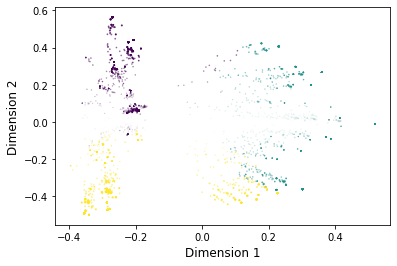

In [174]:
import matplotlib.pyplot as plt
area = np.pi*(PC3[:, 1])**2
plt.scatter(PC3[:, 0], PC3[:, 1], s=area, c=labels.astype(np.float64), alpha=0.5)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

#plt.legend(loc='loweright', title='Legend', frameon='True')

plt.show()

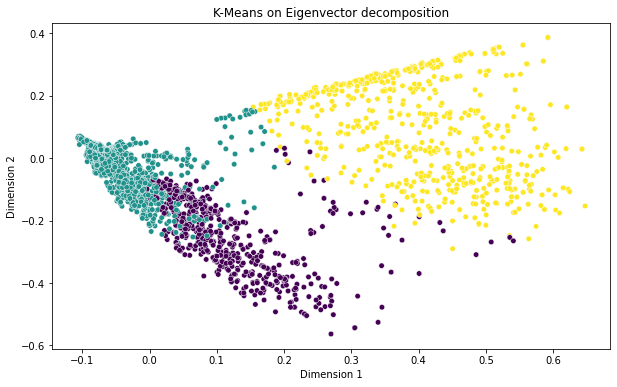

In [30]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x = PC3[:, 0], y = PC3[:, 1], s=30, c=labels, ax=ax)
ax.set(title='K-Means on Eigenvector decomposition', ylabel='Dimension 2', xlabel='Dimension 1');

#sns.reset_orig() вырубает все настройки seaborn по цвету, можно снова юзать matplotlib в дефолтных цветах

In [31]:
Right_join = pd.merge(df, 
                      df_clustered[['publication_number', 'Cluster']],
                      on ='publication_number',
                      how ='left')
Right_join

#Подтянули номера кластеров в изначальную табличку с дубликатами патентных заявок

,publication_number,country_code,priority_yr,cpc4,text,Pub,CitedBy,Contains CPC,Cluster
0,US-5544161-A,US,1995.0,H04L2012/5,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0,0
1,US-5544161-A,US,1995.0,H04N21/643,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0,0
2,US-5544161-A,US,1995.0,H04H20/46,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0,0
3,US-5544161-A,US,1995.0,H04H20/42,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0,0
4,US-5544161-A,US,1995.0,H04N21/438,What is claimed is: \n \n 1. A netwo...,US-5544161-A,500,1.0,0
...,...,...,...,...,...,...,...,...,...
60111,US-2020250683-A1,US,2019.0,G06F40/186,What is claimed is: \n \n 1 . A me...,US-2020250683-A1,4,1.0,1
60112,US-2020250683-A1,US,2019.0,H04L9/3239,What is claimed is: \n \n 1 . A me...,US-2020250683-A1,4,1.0,1
60113,US-2020250683-A1,US,2019.0,H04L9/0866,What is claimed is: \n \n 1 . A me...,US-2020250683-A1,4,1.0,1
60114,US-2020250683-A1,US,2019.0,H04L2209/3,What is claimed is: \n \n 1 . A me...,US-2020250683-A1,4,1.0,1


In [32]:
Calc = pd.DataFrame() #Создали новый датафрейм
Calc.insert(0, "Cluster", Right_join.Cluster.dropna().unique(), True) #Создали колонку Cluster и положили туда уникальные значения из Right_join
Calc = Calc.sort_values(by='Cluster').reset_index(drop=True) #Сортировка колонки Cluster
Calc['Number of publications'] = df_clustered['Cluster'].value_counts() #Нашли сколько публикаций в каждом кластере
#Calc['Number of fwd citations in cluster'].iloc[0] = df_clustered[df_clustered.Cluster == 0].count()
#Cl0 = df_clustered.query("Cluster == 0")['CitedBy'].sum()
#Cl1 = df_clustered.query("Cluster == 1")['CitedBy'].sum()
#Cl2 = df_clustered.query("Cluster == 2")['CitedBy'].sum()
#Calc.loc[Calc.index[0], 'Number of fwd citations in cluster'] = df_clustered[df_clustered.Cluster == 0].count()
max_value = df_clustered['Cluster'].max() #Сделал циклом while, теперь не привязаны к количеству кластеров
i = 0
while i <= max_value:
    fwd_cites = df_clustered[df_clustered['Cluster']==i]['CitedBy'].sum()
    Calc.loc[Calc.index[i], 'Number of forward citations in cluster'] = fwd_cites
    Calc.loc[Calc.index[i], 'Forward cites per patent in cluster'] =  fwd_cites/Calc.loc[Calc.index[i], 'Number of publications']
    tpf = df_clustered.loc[(df_clustered['Cluster']==i)&((df_clustered['country_code'] == 'US')|(df_clustered['country_code'] == 'EPO')|(df_clustered['country_code'] == 'JP'))]['country_code'].count()
    Calc.loc[Calc.index[i], 'Publicated in USPTO/EPO/JP'] = tpf
    Calc.loc[Calc.index[i], 'Triadic patent family'] = tpf/Calc.loc[Calc.index[i], 'Number of publications']
    i += 1
Calc

,Cluster,Number of publications,Number of forward citations in cluster,Forward cites per patent in cluster,Publicated in USPTO/EPO/JP,Triadic patent family
0,0,631,44729.0,70.885895,631.0,1.0
1,1,5902,415480.0,70.396476,5902.0,1.0
2,2,678,62712.0,92.495575,678.0,1.0


In [33]:
Cl0 = pd.DataFrame(Right_join.query("Cluster == 0")['cpc4'].value_counts())
Cl0.rename(columns = {'cpc4':'Count'}, inplace = True)
Cl0['%'] = (Cl0['Count'] / Cl0['Count'].sum()) * 100
Cl0 = Cl0.nlargest(10, '%')
Cl0

,Count,%
G06F3/011,74,1.238908
G02B27/017,72,1.205424
G02B2027/0,68,1.138456
G06T19/006,61,1.021262
G06F3/017,49,0.820358
G06F3/013,43,0.719906
G06F3/0481,31,0.519002
G06F3/012,26,0.435292
G06F3/0484,26,0.435292
G06F3/016,26,0.435292


In [34]:
Cl1 = pd.DataFrame(Right_join.query("Cluster == 1")['cpc4'].value_counts())
Cl1.rename(columns = {'cpc4':'Count'}, inplace = True)
Cl1['%'] = (Cl1['Count'] / Cl1['Count'].sum()) * 100
Cl1 = Cl1.nlargest(10, '%')
Cl1

,Count,%
G02B27/017,547,1.138895
G02B2027/0,518,1.078515
G06F3/011,498,1.036874
G06T19/006,487,1.013971
G06F3/017,308,0.641279
G06F3/013,282,0.587145
G06F3/0481,268,0.557996
G06T2207/1,224,0.466385
G06T2207/3,211,0.439318
G06F2203/0,197,0.410169


In [35]:
Cl2 = pd.DataFrame(Right_join.query("Cluster == 2")['cpc4'].value_counts())
Cl2.rename(columns = {'cpc4':'Count'}, inplace = True)
Cl2['%'] = (Cl2['Count'] / Cl2['Count'].sum()) * 100
Cl2 = Cl2.nlargest(10, '%')
Cl2

,Count,%
G02B27/017,80,1.308472
G02B2027/0,74,1.210337
G06T19/006,63,1.030422
G06F3/011,57,0.932287
G06F3/0481,34,0.556101
G06F3/017,32,0.523389
G06T2207/3,30,0.490677
Y10S707/99,28,0.457965
A63F2300/1,27,0.441609
G06F2203/0,27,0.441609


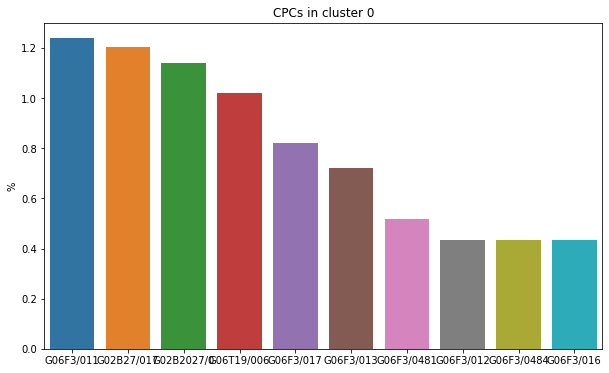

In [36]:
fig0, ax0 = plt.subplots(figsize=(10, 6))
#sns.lineplot(x = year['year'], y = year['number of publications'], ax=ax1)
sns.barplot(data=Cl0, x=Cl0.index, y='%')
ax0.set(title='CPCs in cluster 0');

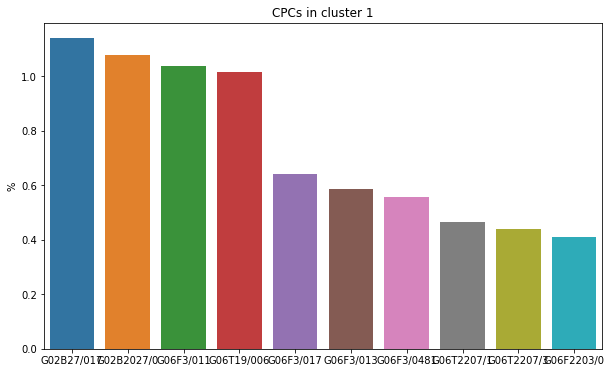

In [37]:
fig2, ax2 = plt.subplots(figsize=(10, 6))
#sns.lineplot(x = year['year'], y = year['number of publications'], ax=ax1)
sns.barplot(data=Cl1, x=Cl1.index, y='%')
ax2.set(title='CPCs in cluster 1');

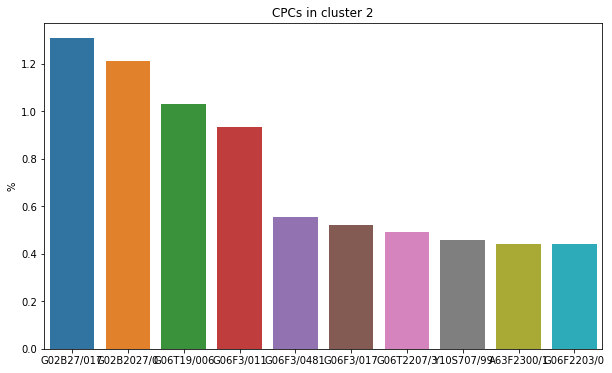

In [38]:
fig3, ax3 = plt.subplots(figsize=(10, 6))
#sns.lineplot(x = year['year'], y = year['number of publications'], ax=ax1)
sns.barplot(data=Cl2, x=Cl2.index, y='%')
ax3.set(title='CPCs in cluster 2');

In [28]:
Right_join.country_code.dropna().unique()

array(['US'], dtype=object)

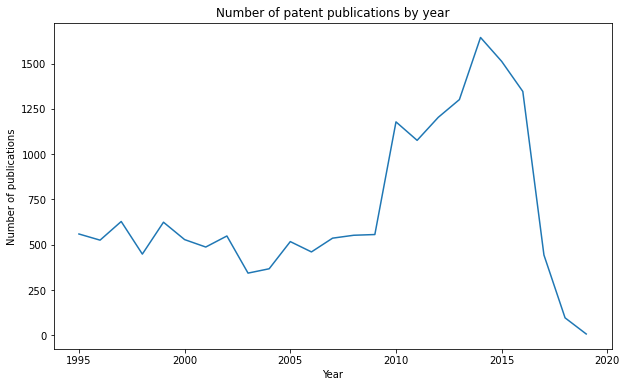

In [76]:
# Do we have a mix of data from 1995-present?
year = pd.DataFrame(df.priority_yr.value_counts().sort_index())
year.reset_index(inplace=True)
year = year.rename(columns = {'index':'Year'})
year.rename(columns={'priority_yr':'Number of publications'}, inplace=True)

fig1, ax1 = plt.subplots(figsize=(10, 6))
#sns.lineplot(x = year['year'], y = year['number of publications'], ax=ax1)
sns.lineplot(data=year, x='Year', y='Number of publications')
ax1.set(title='Number of patent publications by year');

In [87]:
# What do the claims look like?
# df.sample возвращает случайные 2 записи из датафрейма с формулами изобретения
for claim in df.sample(2).text:
  print('-----' * 5, '\n\nEXAMPLE CLAIM: \n\n', claim[:3000])

------------------------- 

EXAMPLE CLAIM: 

 The invention claimed is: 
     
       1. A key connectable with an exercise device, the key comprising:
 a safety mechanism that is operatively connectable to a safety port on an exercise device, wherein the safety mechanism places the exercise device in an operational configuration when the safety mechanism is operatively connected to the safety port, and wherein the exercise device is in a non-operational configuration when the safety mechanism is not operatively connected to the safety port; and 
 a user identification mechanism that is communicatively connectable to a user identification port on the exercise device, wherein the user identification mechanism transmits user identification information to the exercise device when the user identification mechanism is communicatively connected to the user identification port, the user identification information comprises key identifying information. 
 
     
     
       2. The key of  clai

## Extract the First Claims Using A UDF in Big Query

Since we have the full claim above, we need a way to parse out just the first claim. BigQuery has [User Defined Functions (UDF's)](https://cloud.google.com/bigquery/docs/reference/standard-sql/user-defined-functions) which let the user pass columns through some arbitrary function. In our case, we need some logic to parse the claims and split after the first claim has ended. In most cases we can simply split on the text "1." but there are also cases where the text is not so cleanly formatted. The UDF below shows and example of using javascript regular expressions to parse the first claim.

The basic logic is to work down the following options, returning the first positive match:

1. Try to split on '2.' or '2 .'.
2. Find the first mention of 'claim 1' and split there.
3. Handle canceled claims by finding the word canceled and determining which claim was the first non-canceled claim.
4. Look for a sentence beginning with "The" - split and return the first half.
5. Finally, just return the first 2000 characters. 

RUS: Поскольку у нас есть полный набор формул изобретения выше, нам нужен способ проанализировать только первую формулу. В BigQuery есть [определяемые пользователем функции (UDF)] (https://cloud.google.com/bigquery/docs/reference/standard-sql/user-defined-functions), которые позволяют пользователю передавать столбцы через произвольную функцию. В нашем случае нам нужна некоторая логика для синтаксического анализа заявок и разделения после того, как первая заявка закончилась. В большинстве случаев мы можем просто разделить текст «1». но есть также случаи, когда текст не так четко отформатирован. В UDF ниже показан пример использования регулярных выражений javascript для анализа первого утверждения.

Основная логика состоит в том, чтобы проработать следующие параметры, возвращая первое положительное совпадение:

1. Попробуйте разделить на '2.' или '2 .'.
2. Найдите первое упоминание «формулы изобретения 1» и разделите его.
3. Обработайте отмененные претензии, найдя слово отменен и определив, какая претензия была первой неотмененной претензией.
4. Найдите предложение, начинающееся с «The» - разделите и верните первую половину.
5. Наконец, просто верните первые 2000 символов.

In [88]:
# The JS script to run against the text of our claims.
js = r"""

// Regex to find a period followed by any number of spaces and '2.' or '2 .'
var pattern = new RegExp(/[.][\\s]+[2][\\s]*[.]/, 'g');
if (pattern.test(text)) {
  return text.split(pattern)[0];
}

// If none of the above worked, try to find a reference to claim 1.
if (text.indexOf('claim 1 ') > -1) {
  return text.split('claim 1 ')[0];
}

// Look for claim cancelations and return first non-canceled claim
text = text.replace(/canceled/i, 'canceled')
text = text.replace(/cancelled/i, 'canceled')
if (text.indexOf('(canceled)') > -1) {
	text = text.split('(canceled)')
	canceled = text[0];
	not_canceled = text[1];
	// Determine first non-cancelled claim
	if (canceled.indexOf('-') > -1 ) {
		next_claim = parseInt(canceled.split('-')[1]) + 1
	}
	else {
		next_claim = 2;
	}
	// Split on next_claim + 1
	return not_canceled.split(next_claim + 1)[0].trim();
}


// If none of the above worked, try to find a sentence starting with 'The'
// This should only happen after claim 1 has been defined.
if (text.indexOf(' The ') > -1) {
  return text.split(' The ')[0];
}

// if none of the above worked return the first 2000 characters. 
return text.slice(0,2000);
"""

In [89]:
# Insert the JS code above into this string, and pass it to Big Query
query = r'''
#standardSQL
CREATE TEMPORARY FUNCTION get_first_claim(text STRING)
RETURNS STRING
LANGUAGE js AS """
{}
"""; 

 
SELECT 
pubs.*, 
get_first_claim(text) first_claim
FROM `{}.{}.virtual-reality` pubs
'''.format(js, PROJECT_ID, DEST_DATASET)
CLAIM_TEXT_TABLE = 'virtual-reality_split_first_claim'
create_table_as(query, CLAIM_TEXT_TABLE)

Job still running...
Job still running...
Job still running...
Created table virtual-reality_split_first_claim.


In [90]:
query = """
SELECT * FROM `{}.{}.{}` WHERE RAND() < 500/20000 
""".format(PROJECT_ID, DEST_DATASET, CLAIM_TEXT_TABLE)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

## Let's See how that UDF Performed

One way to test the UDF would be to run a query in bigquery against an example we can test. For example:

```SELECT get_first_claim("1. test claim 1 2. test claim 2");```

We can also run this claim against real data and pull down a sample, which is shown below. We've now created a new table which has both the full claims text as well as our extracted first claim. Lets compare a few to see how well it worked.

RUS: Один из способов протестировать UDF - запустить запрос в bigquery на примере, который мы можем протестировать. Например:

```SELECT get_first_claim("1. test claim 1 2. test claim 2");```

Мы также можем запустить это утверждение на основе реальных данных и получить образец, который показан ниже. Теперь мы создали новую таблицу, в которой есть как полный текст претензии, так и извлеченная первая претензия. Давайте сравним несколько, чтобы увидеть, насколько хорошо это сработало.

In [91]:
for idx, row in df.sample(2).iterrows():
  print('------' * 10, '\nORIGINAL CLAIM TEXT:\n', '------' * 10)
  print(row.text[:2000], '\n')
  print('------' * 10, '\nRESULT AFTER PARSING WITH UDF:\n', '------' * 10)
  print(row.first_claim, '...\n\n')

------------------------------------------------------------ 
ORIGINAL CLAIM TEXT:
 ------------------------------------------------------------
What is claimed is: 
     
       1. An X-ray photography apparatus comprising:
 a support that supports an X-ray generator and an X-ray detector while said X-ray generator and said X-ray detector are opposed to each other so that a head of a patient can be interposed therebetween, the X-ray detector outputting an electric signal according to an intensity of an incident X-ray; 
 a moving mechanism that includes a turning part and a moving part, the turning part relatively turning said X-ray generator and said X-ray detector about the head by turning said support relative to the head about a predetermined turning axis, and the moving part moving said support relative to the head in a direction perpendicular to said turning axis; 
 a photographic region designation part that designates part of a row of teeth along a dental arch as a pseudo-intra

# Lastly, lets use BigQuery to calculate some statistics about the first claim.

From the start, the goal here was to compute some summary statistics about claims for a specific set of patents. Namely, we're interested to see if the number of elements, character counts, or word counts have varied over time. 

RUS: С самого начала целью здесь было вычислить некоторую сводную статистику по заявкам на определенный набор патентов. А именно, нам интересно узнать, менялось ли количество элементов, количество символов или слов со временем.

-----------------

## Average Word Count by Year

In [23]:
# Average Word Count by Year:
query = r"""
#standardSQL
with words as (
  SELECT 
  publication_number,
  priority_yr,
  SPLIT(REGEXP_REPLACE(first_claim, r'\s{2,}', ''), ' ') word
  FROM `%s.%s.%s`
)

SELECT 
  priority_yr, 
  avg(num_words) avg_word_cnt
FROM (
  SELECT
  publication_number,
  priority_yr,
  count(*) as num_words
  from words, unnest(word)
  group by 1,2
)
GROUP BY 1
ORDER BY 1
""" %(PROJECT_ID, DEST_DATASET, CLAIM_TEXT_TABLE)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

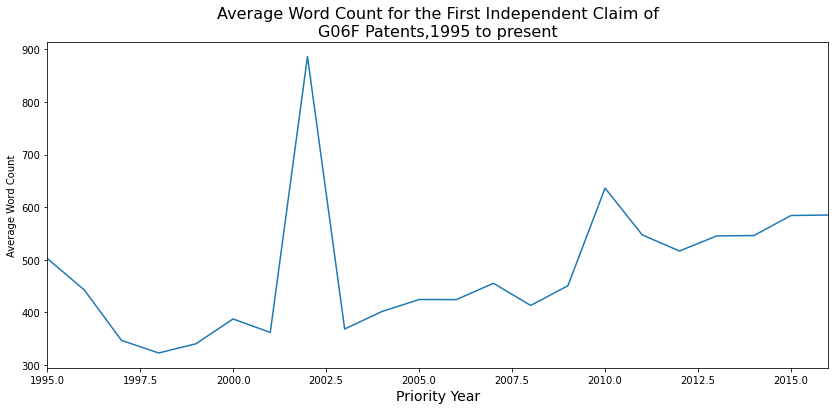

In [24]:
plt.figure(figsize=(14, 6))
plt.plot(df.priority_yr, df.avg_word_cnt)
plt.xlabel('Priority Year', fontsize=14)
plt.xlim(1995, 2016)
plt.ylabel('Average Word Count')
plt.title('Average Word Count for the First Independent Claim of\nG06F Patents,'
          '1995 to present', fontsize=16)
plt.show()

## Average Number of Elements by Year

In [25]:
query = """
#standardSQL
with elements as (
  SELECT 
  publication_number,
  priority_yr,
  SPLIT(first_claim, ';') element
  FROM `%s.%s.%s`
)

SELECT 
  priority_yr, 
  avg(num_elements) avg_element_cnt
FROM (
  SELECT
  publication_number,
  priority_yr,
  count(*) as num_elements
  from elements, unnest(element)
  group by 1,2
)
GROUP BY 1
ORDER BY 1
""" %(PROJECT_ID, DEST_DATASET, CLAIM_TEXT_TABLE)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

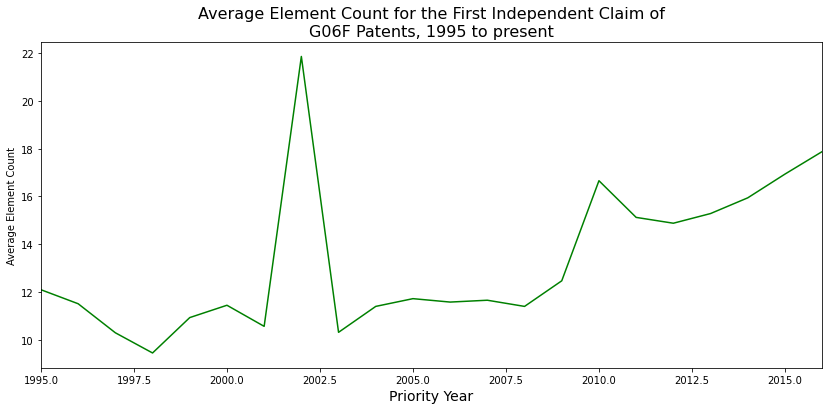

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(df.priority_yr, df.avg_element_cnt, color='g')
plt.xlabel('Priority Year', fontsize=14)
plt.xlim(1995, 2016)
plt.ylabel('Average Element Count')
plt.title('Average Element Count for the First Independent Claim of\n'
          'G06F Patents, 1995 to present', fontsize=16)
plt.show()